In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


In [98]:
generation = pd.read_csv("datasets/Generacion_fotovoltaica_imputed.csv", sep=",")

In [99]:
# Rename columns to Prophet defaults
generation.rename(columns={'FECHA': 'ds', 'TOTAL_KWH_ENERGIA': 'y'}, inplace=True)

# Convert the 'ds' column to datetime
generation['ds'] = pd.to_datetime(generation['ds'])

# Augment the dataset with year, month, day, and hour
generation['year'] = generation['ds'].dt.year
generation['month'] = generation['ds'].dt.month
generation['day'] = generation['ds'].dt.day
generation['hour'] = generation['ds'].dt.hour

# Note: Extracting the day of the week (0-6, where 0 is Monday)
generation['weekday'] = generation['ds'].dt.weekday

generation['is_weekend'] = (generation['weekday'] >= 5).astype(int)  # 1 if Sat/Sun, else 0

#Augmented dataset
generation = generation[['ds', 'year', 'month', 'day', 'weekday', 'is_weekend', 'hour', 'y']]

# Clip negative values in 'y' to 0
generation['y'] = generation['y'].clip(lower=0)


generation

,ds,year,month,day,weekday,is_weekend,hour,y
0,2023-07-24 11:00:00,2023,7,24,0,0,11,50.621836
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.660000
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.980000
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.350000
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.900000
...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,2024,8,31,5,1,19,26.658156
9704,2024-08-31 20:00:00,2024,8,31,5,1,20,12.578520
9705,2024-08-31 21:00:00,2024,8,31,5,1,21,2.978687
9706,2024-08-31 22:00:00,2024,8,31,5,1,22,0.285475


In [100]:
generation.shape

(9708, 8)

In [101]:
# Add lagged columns
generation['y_lag_6'] = generation['y'].shift(6)
generation['y_lag_12'] = generation['y'].shift(12)
generation['y_lag_24'] = generation['y'].shift(24)

# Display the updated DataFrame
generation.head(30)  # Display the first 30 rows to see the lagged values

,ds,year,month,day,weekday,is_weekend,hour,y,y_lag_6,y_lag_12,y_lag_24
0,2023-07-24 11:00:00,2023,7,24,0,0,11,50.621836,NaN,NaN,NaN
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.660000,NaN,NaN,NaN
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.980000,NaN,NaN,NaN
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.350000,NaN,NaN,NaN
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.900000,NaN,NaN,NaN
5,2023-07-24 16:00:00,2023,7,24,0,0,16,126.930000,NaN,NaN,NaN
6,2023-07-24 17:00:00,2023,7,24,0,0,17,121.220000,50.621836,NaN,NaN
7,2023-07-24 18:00:00,2023,7,24,0,0,18,91.340000,115.660000,NaN,NaN
8,2023-07-24 19:00:00,2023,7,24,0,0,19,58.930000,129.980000,NaN,NaN
9,2023-07-24 20:00:00,2023,7,24,0,0,20,26.850000,134.350000,NaN,NaN


In [102]:
meteo = pd.read_csv("datasets/Meteorologia.csv", sep=",")

In [103]:
generation.shape
meteo.shape

(100557, 27)

In [104]:
len(meteo["FORECAST_TIMESTAMP"].unique())

11173

<Axes: >

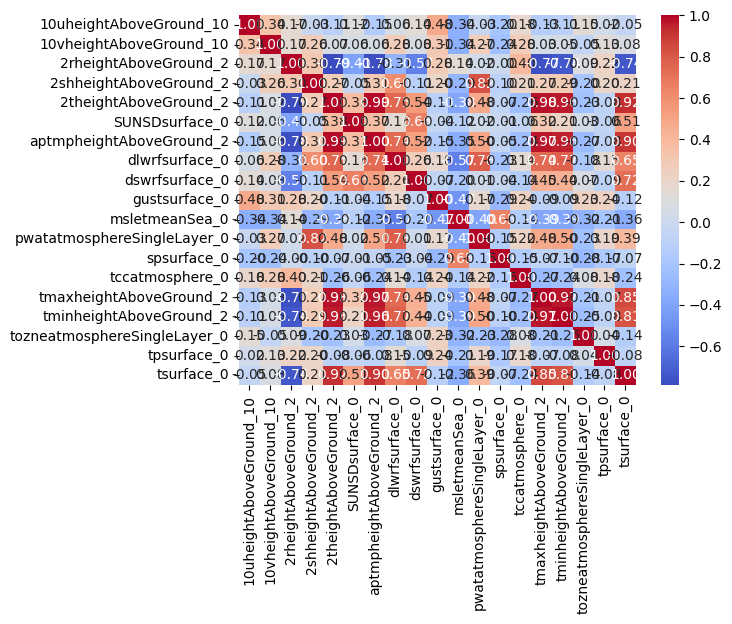

In [105]:
aux = meteo.drop(columns=['FORECAST_TIMESTAMP', 'LATITUDE', 'LONGITUDE'])
aux.drop(columns=["uheightAboveGround_80","vheightAboveGround_80","presheightAboveGround_80", "qheightAboveGround_80","theightAboveGround_80"], inplace=True)
sns.heatmap(aux.corr(), annot=True, cmap='coolwarm', fmt='.2f')

<Axes: >

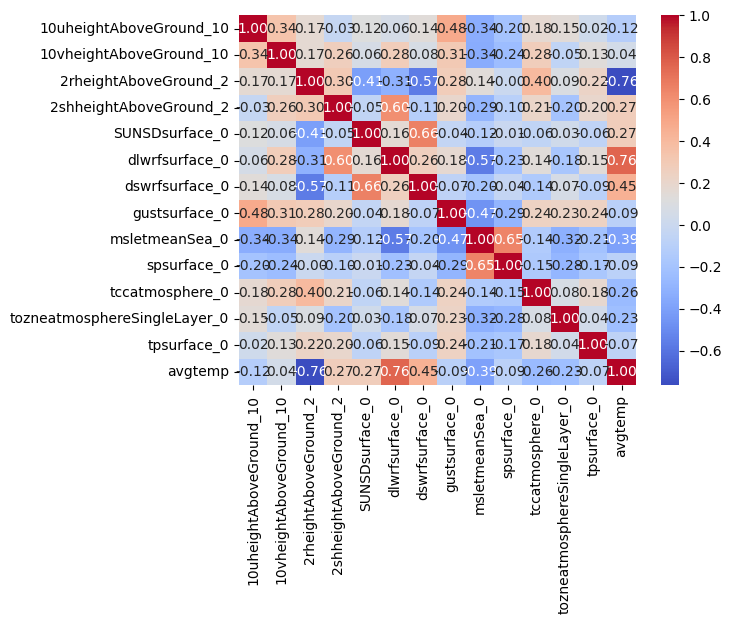

In [106]:
aux["avgtemp"] = (aux["tmaxheightAboveGround_2"] * aux["tminheightAboveGround_2"]) / 2
aux.drop(columns=["tsurface_0","pwatatmosphereSingleLayer_0", "2theightAboveGround_2","aptmpheightAboveGround_2", "tmaxheightAboveGround_2", "tminheightAboveGround_2"], inplace=True)
sns.heatmap(aux.corr(), annot=True, cmap='coolwarm', fmt='.2f')

In [107]:
meteo.drop(columns=["uheightAboveGround_80","vheightAboveGround_80","presheightAboveGround_80", "qheightAboveGround_80","theightAboveGround_80", "tsurface_0","pwatatmosphereSingleLayer_0", "2theightAboveGround_2","aptmpheightAboveGround_2", "tmaxheightAboveGround_2", "tminheightAboveGround_2"], inplace=True)

In [108]:
# Group by FORECAST_TIMESTAMP and calculate the mean for all columns
meteo_averages = meteo.groupby('FORECAST_TIMESTAMP').mean()

# Display the resulting DataFrame
meteo_averages.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0
FORECAST_TIMESTAMP,,,,,,,,,,,,,,,
2023-07-24 11:00:00+00:00,40.250000,-3.750000,5.176383,2.306685,17.577778,0.004644,18000.000000,320.641024,568.753333,6.822393,100961.961111,94006.964236,2.700000,324.906396,0.000000
2023-07-24 12:00:00+00:00,40.250000,-3.750000,5.670802,2.579575,16.988889,0.004856,21600.000000,324.429913,634.458667,7.719673,100871.676389,93949.704861,3.800000,325.770036,0.000000
2023-07-24 13:00:00+00:00,40.250000,-3.750000,6.260587,2.442148,17.077778,0.005225,3600.000000,352.366667,979.857778,8.547689,100780.619444,93885.935417,38.833333,326.296606,0.000000
2023-07-24 14:00:00+00:00,40.250000,-3.750000,7.004427,2.025345,17.266667,0.005513,7200.000000,356.926508,956.262222,9.332581,100706.934722,93829.203819,23.177778,327.157633,0.000000
2023-07-24 15:00:00+00:00,40.250000,-3.750000,7.471493,2.054768,17.411111,0.005703,10800.000000,360.544444,914.748889,9.640562,100637.983333,93770.919444,58.177778,330.289266,0.000000


In [109]:
# Reset the index to bring FORECAST_TIMESTAMP back as a column
meteo_averages.reset_index(inplace=True)

# Convert FORECAST_TIMESTAMP to datetime if necessary
meteo_averages['FORECAST_TIMESTAMP'] = pd.to_datetime(meteo_averages['FORECAST_TIMESTAMP'])

In [110]:
meteo_filtered = meteo_averages.drop(columns=['LATITUDE', 'LONGITUDE'])
meteo_filtered['FORECAST_TIMESTAMP'] = meteo_filtered['FORECAST_TIMESTAMP'].dt.tz_localize(None)  # Remove timezone
generation['ds'] = generation['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

generation = generation.merge(meteo_filtered, left_on='ds', right_on='FORECAST_TIMESTAMP', how='left')

# Drop the 'FORECAST_TIMESTAMP' column after merging (if you don't need it)
generation.drop(columns=['FORECAST_TIMESTAMP'], inplace=True)

# Optionally, reorder the column 'y' back to its original position if needed
#aux = generation['y']
#generation = generation.drop(columns=['y'])
#generation['y'] = aux

# Display the first few rows of the result
generation.head()

,ds,year,month,day,weekday,is_weekend,hour,y,y_lag_6,y_lag_12,...,2shheightAboveGround_2,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0
0,2023-07-24 11:00:00,2023,7,24,0,0,11,50.621836,NaN,NaN,...,0.004644,18000.000000,320.641024,568.753333,6.822393,100961.961111,94006.964236,2.700000,324.906396,0.000000
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.660000,NaN,NaN,...,0.004856,21600.000000,324.429913,634.458667,7.719673,100871.676389,93949.704861,3.800000,325.770036,0.000000
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.980000,NaN,NaN,...,0.005225,3600.000000,352.366667,979.857778,8.547689,100780.619444,93885.935417,38.833333,326.296606,0.000000
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.350000,NaN,NaN,...,0.005513,7200.000000,356.926508,956.262222,9.332581,100706.934722,93829.203819,23.177778,327.157633,0.000000
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.900000,NaN,NaN,...,0.005703,10800.000000,360.544444,914.748889,9.640562,100637.983333,93770.919444,58.177778,330.289266,0.000000


In [111]:
from sklearn.preprocessing import MinMaxScaler

generation["hour_sin"] = np.sin(2 * np.pi * generation["hour"] / 24)
generation["hour_cos"] = np.cos(2 * np.pi * generation["hour"] / 24)
generation.drop(["hour"], axis=1, inplace=True)

In [112]:
scalers = {}
for col in generation.columns:
    if col not in ["ds"]:  # Exclude timestamp
        scalers[col] = MinMaxScaler()
        generation[col] = scalers[col].fit_transform(generation[[col]])

In [113]:
generation.shape

(9708, 25)

In [114]:
missing_columns = generation.columns[generation.isnull().any()]
print("Columns with missing values:", missing_columns)

Columns with missing values: Index(['y_lag_6', 'y_lag_12', 'y_lag_24'], dtype='object')


In [115]:
generation = generation.drop(columns=(missing_columns))

In [116]:
# Define the cutoff date for the train-test split
cutoff_date = '2024-07-31'
# Training data is strictly before the test period and avoids Data Leakage.
# No shuffling is done, preserving the Chronological Order.


# Split into train (before May 1st) and test (from May 1st onwards until June 1st)
train_df = generation[generation['ds'] <= cutoff_date]
test_df = generation[generation['ds'] > cutoff_date]

In [117]:
generation

,ds,year,month,day,weekday,is_weekend,y,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,hour_sin,hour_cos
0,2023-07-24 11:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.330754,0.590779,0.527927,0.116773,...,0.452105,0.563247,0.248037,0.427777,0.503320,0.027000,0.307271,0.000000,0.629410,0.017037
1,2023-07-24 12:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.755701,0.609859,0.539032,0.110265,...,0.469831,0.628317,0.282421,0.410131,0.491380,0.038000,0.310399,0.000000,0.500000,0.000000
2,2023-07-24 13:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.849265,0.632620,0.533440,0.111248,...,0.600533,0.970372,0.314150,0.392334,0.478083,0.388333,0.312307,0.000000,0.370590,0.017037
3,2023-07-24 14:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.877818,0.661326,0.516478,0.113335,...,0.621866,0.947005,0.344226,0.377933,0.466253,0.231778,0.315425,0.000000,0.250000,0.066987
4,2023-07-24 15:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.874877,0.679351,0.517676,0.114931,...,0.638793,0.905893,0.356028,0.364457,0.454100,0.581778,0.326768,0.000000,0.146447,0.146447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,1.000000,0.636364,1.000000,0.833333,1.000000,0.174179,0.442784,0.470447,0.472741,...,0.754641,0.022339,0.096622,0.441298,0.510163,0.152333,0.229205,0.001192,0.017037,0.629410
9704,2024-08-31 20:00:00,1.000000,0.636364,1.000000,0.833333,1.000000,0.082186,0.407644,0.463103,0.496071,...,0.735267,0.011173,0.066118,0.449921,0.514652,0.957000,0.232174,0.002085,0.066987,0.750000
9705,2024-08-31 21:00:00,1.000000,0.636364,1.000000,0.833333,1.000000,0.019462,0.376682,0.479347,0.508718,...,0.730103,0.007447,0.065425,0.456211,0.518327,1.000000,0.227879,0.002383,0.146447,0.853553
9706,2024-08-31 22:00:00,1.000000,0.636364,1.000000,0.833333,1.000000,0.001865,0.349159,0.488822,0.527505,...,0.738554,0.005590,0.110729,0.462209,0.521863,1.000000,0.226230,0.008937,0.250000,0.933013


## LSTM Training

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
class EnergyDataset(Dataset):
    def __init__(self, data, target_col="y", seq_length=6):
        self.data = data
        self.target_col = target_col
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        X = self.data.iloc[index:index + self.seq_length].drop(["ds", self.target_col], axis=1).values
        y = self.data.iloc[index + self.seq_length][self.target_col]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [120]:
len(generation)

9708

In [121]:
seq_length = 6  # Use past 6 hours to predict the next value
train_dataset = EnergyDataset(train_df, seq_length=seq_length)
test_dataset = EnergyDataset(test_df, seq_length=seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffling for time series
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)  # Predicts one value per sequence

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Take the last time step output


# Initialize model
input_size = generation.shape[1] - 2  # Exclude "ds" and "y"
model = LSTMModel(input_size)

In [148]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.5f}")

Epoch 1/20, Loss: 0.00974
Epoch 2/20, Loss: 0.00951
Epoch 3/20, Loss: 0.00937
Epoch 4/20, Loss: 0.00946
Epoch 5/20, Loss: 0.00939
Epoch 6/20, Loss: 0.00930
Epoch 7/20, Loss: 0.00926
Epoch 8/20, Loss: 0.00925
Epoch 9/20, Loss: 0.00924
Epoch 10/20, Loss: 0.00935
Epoch 11/20, Loss: 0.00897
Epoch 12/20, Loss: 0.00899
Epoch 13/20, Loss: 0.00876
Epoch 14/20, Loss: 0.00868
Epoch 15/20, Loss: 0.00869
Epoch 16/20, Loss: 0.00853
Epoch 17/20, Loss: 0.00836
Epoch 18/20, Loss: 0.00814
Epoch 19/20, Loss: 0.00815
Epoch 20/20, Loss: 0.00808


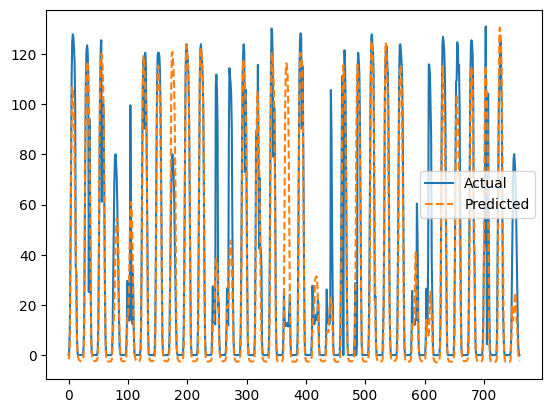

In [149]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        predictions.extend(y_pred.tolist())
        actuals.extend(y_batch.tolist())

# Convert back from normalized scale
actuals = scalers["y"].inverse_transform(np.array(actuals).reshape(-1, 1))
predictions = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot results
import matplotlib.pyplot as plt

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted", linestyle="dashed")
plt.legend()
plt.show()

In [150]:
aux = generation.iloc[-24:].drop(["ds", "y"], axis=1).values
last_seq = torch.tensor(aux, dtype=torch.float32).unsqueeze(0)
len(last_seq)

1

In [151]:
def forecast_next_month(model, df, seq_length, steps=24*30):
    model.eval()
    df = df.drop(["ds"], axis=1)
    last_seq = df.iloc[-seq_length:].values
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)

    future_preds = []
    for _ in range(steps):
        with torch.no_grad():
            pred = model(last_seq).item()
            future_preds.append(pred)

        # Update sequence for next prediction
        new_row = last_seq[:, 1:, :].clone()  # Shift left
        new_features = torch.tensor(df.iloc[-1].values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        last_seq = torch.cat((new_row, new_features), dim=1)

    # Convert back from normalized scale
    future_preds = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

    return future_preds

Please review to see if I fucked up or something because these results CANNOT be right

# From here under it's for generating the predicitons.

In [152]:
generation

,ds,year,month,day,weekday,is_weekend,y,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,hour_sin,hour_cos
0,2023-07-24 11:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.330754,0.590779,0.527927,0.116773,...,0.452105,0.563247,0.248037,0.427777,0.503320,0.027000,0.307271,0.000000,0.629410,0.017037
1,2023-07-24 12:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.755701,0.609859,0.539032,0.110265,...,0.469831,0.628317,0.282421,0.410131,0.491380,0.038000,0.310399,0.000000,0.500000,0.000000
2,2023-07-24 13:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.849265,0.632620,0.533440,0.111248,...,0.600533,0.970372,0.314150,0.392334,0.478083,0.388333,0.312307,0.000000,0.370590,0.017037
3,2023-07-24 14:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.877818,0.661326,0.516478,0.113335,...,0.621866,0.947005,0.344226,0.377933,0.466253,0.231778,0.315425,0.000000,0.250000,0.066987
4,2023-07-24 15:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.874877,0.679351,0.517676,0.114931,...,0.638793,0.905893,0.356028,0.364457,0.454100,0.581778,0.326768,0.000000,0.146447,0.146447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,1.000000,0.636364,1.000000,0.833333,1.000000,0.174179,0.442784,0.470447,0.472741,...,0.754641,0.022339,0.096622,0.441298,0.510163,0.152333,0.229205,0.001192,0.017037,0.629410
9704,2024-08-31 20:00:00,1.000000,0.636364,1.000000,0.833333,1.000000,0.082186,0.407644,0.463103,0.496071,...,0.735267,0.011173,0.066118,0.449921,0.514652,0.957000,0.232174,0.002085,0.066987,0.750000
9705,2024-08-31 21:00:00,1.000000,0.636364,1.000000,0.833333,1.000000,0.019462,0.376682,0.479347,0.508718,...,0.730103,0.007447,0.065425,0.456211,0.518327,1.000000,0.227879,0.002383,0.146447,0.853553
9706,2024-08-31 22:00:00,1.000000,0.636364,1.000000,0.833333,1.000000,0.001865,0.349159,0.488822,0.527505,...,0.738554,0.005590,0.110729,0.462209,0.521863,1.000000,0.226230,0.008937,0.250000,0.933013


In [153]:
meteo.head()

,FORECAST_TIMESTAMP,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0
0,2023-07-24 11:00:00+00:00,40.000000,-4.000000,6.989717,1.524463,19.600000,0.005070,18000.000000,318.407690,567.660000,8.100171,101020.450000,95095.853125,0.800000,324.006396,0.000000
1,2023-07-24 12:00:00+00:00,40.000000,-4.000000,7.526357,1.301797,18.400000,0.005260,21600.000000,323.107690,633.552000,9.030784,100928.387500,95033.793750,1.700000,325.803369,0.000000
2,2023-07-24 13:00:00+00:00,40.000000,-4.000000,8.506143,1.294370,18.200000,0.005665,3600.000000,357.800000,980.840000,9.903244,100824.975000,94955.268750,8.800000,326.096606,0.000000
3,2023-07-24 14:00:00+00:00,40.000000,-4.000000,9.392205,1.283123,17.400000,0.005709,7200.000000,362.248730,959.700000,11.210358,100756.912500,94899.959375,5.000000,326.790967,0.000000
4,2023-07-24 15:00:00+00:00,40.000000,-4.000000,10.167048,1.555879,18.300000,0.006080,10800.000000,365.100000,921.100000,11.729451,100686.450000,94838.475000,35.800000,329.955933,0.000000


In [154]:
cutoff_date = '2024-09-01'
cutoff_date1 = '2024-10-01'
aux = meteo[meteo['FORECAST_TIMESTAMP'] > cutoff_date]
aux = aux[aux['FORECAST_TIMESTAMP'] < cutoff_date1]

In [155]:
aux.shape

(6480, 16)

In [156]:
aux.head()

,FORECAST_TIMESTAMP,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0
9709,2024-09-01 00:00:00+00:00,40.000000,-4.000000,-2.877146,0.212925,57.300000,0.011819,2700.000000,384.955627,4.288000,3.709302,101113.675000,95107.828125,100.000000,298.993127,0.187500
9710,2024-09-01 01:00:00+00:00,40.000000,-4.000000,-1.166338,-1.198650,68.900000,0.012476,0.000000,378.663379,0.000000,2.106677,101170.468750,95137.556250,100.000000,299.731348,0.375000
9711,2024-09-01 02:00:00+00:00,40.000000,-4.000000,-1.016116,-1.328894,73.100000,0.012697,0.000000,374.763428,0.000000,2.021576,101173.906250,95132.550000,100.000000,298.660120,0.812500
9712,2024-09-01 03:00:00+00:00,40.000000,-4.000000,-0.910071,-1.390093,75.100000,0.012949,0.000000,372.000000,0.000000,2.008297,101133.587500,95090.556250,56.900000,297.191321,1.125000
9713,2024-09-01 04:00:00+00:00,40.000000,-4.000000,-0.045088,-1.112429,75.800000,0.012999,0.000000,370.041504,0.000000,1.103513,101148.581250,95101.356250,86.100000,296.800269,1.125000


In [157]:
testdf = aux.groupby('FORECAST_TIMESTAMP').mean()

testdf.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0
FORECAST_TIMESTAMP,,,,,,,,,,,,,,,
2024-09-01 00:00:00+00:00,40.250000,-3.750000,-2.767146,1.861814,61.322222,0.011785,2591.666667,384.755627,3.756444,5.842635,101199.586111,94125.605903,100.000000,300.937572,1.076389
2024-09-01 01:00:00+00:00,40.250000,-3.750000,-2.001893,-0.224205,71.866667,0.012492,0.000000,370.518934,0.000000,3.640011,101224.335417,94125.645139,100.000000,301.242459,0.430556
2024-09-01 02:00:00+00:00,40.250000,-3.750000,-2.005005,0.027773,74.811111,0.012621,0.000000,368.318983,0.000000,3.588243,101226.439583,94119.572222,99.477778,299.637897,1.006944
2024-09-01 03:00:00+00:00,40.250000,-3.750000,-2.177849,-0.483426,75.255556,0.012733,0.000000,366.544444,0.000000,3.486075,101184.654167,94076.511806,85.600000,298.935765,1.215278
2024-09-01 04:00:00+00:00,40.250000,-3.750000,-1.949532,-0.743540,75.288889,0.012692,0.000000,364.985948,0.000000,2.981291,101180.759028,94068.645139,67.788889,298.833602,1.222222


In [158]:
testdf.reset_index(inplace=True)

# Convert FORECAST_TIMESTAMP to datetime if necessary
testdf['FORECAST_TIMESTAMP'] = pd.to_datetime(testdf['FORECAST_TIMESTAMP'])
testdf.drop(columns=['LATITUDE', 'LONGITUDE'], inplace=True)

In [159]:
future_dates = pd.date_range(start='2024-09-01 00:00:00', end='2024-09-30 23:00:00', freq='h')

# Create an empty DataFrame for predictions
future_df = pd.DataFrame({'ds': future_dates})

# Convert Timestamp Features
future_df['hour'] = future_df['ds'].dt.hour
future_df['year'] = future_df['ds'].dt.year
future_df['month'] = future_df['ds'].dt.month
future_df['day'] = future_df['ds'].dt.day
future_df['weekday'] = future_df['ds'].dt.weekday
future_df['is_weekend'] = (future_df['weekday'] >= 5).astype(int)

In [160]:
testdf['FORECAST_TIMESTAMP'] = testdf['FORECAST_TIMESTAMP'].dt.tz_localize(None)  # Remove timezone
future_df['ds'] = future_df['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

future_df = future_df.merge(testdf, left_on='ds', right_on='FORECAST_TIMESTAMP', how='left')
future_df.drop(columns=['FORECAST_TIMESTAMP'], inplace=True)

In [161]:
# Apply Cyclical Encoding
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)
future_df.drop(["hour"], axis=1, inplace=True)

In [162]:
scalers1 = {}
for col in future_df.columns:
    if col not in ["ds"]:  # Exclude timestamp
        scalers[col] = MinMaxScaler()
        future_df[col] = scalers[col].fit_transform(future_df[[col]])

In [163]:
future_df

,ds,year,month,day,weekday,is_weekend,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,...,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,hour_sin,hour_cos
0,2024-09-01 00:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.198802,0.688282,0.680744,0.907418,...,0.883984,0.004368,0.333398,0.437201,0.483832,1.000000,0.220704,0.181499,0.500000,1.000000
1,2024-09-01 01:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.244571,0.542835,0.817527,0.976431,...,0.776265,0.000000,0.193098,0.448349,0.483854,1.000000,0.226509,0.072600,0.629410,0.982963
2,2024-09-01 02:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.244385,0.560404,0.855722,0.989027,...,0.759619,0.000000,0.189801,0.449296,0.480509,0.994778,0.195960,0.169789,0.750000,0.933013
3,2024-09-01 03:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.234047,0.524761,0.861487,1.000000,...,0.746193,0.000000,0.183293,0.430476,0.456789,0.856000,0.182592,0.204918,0.853553,0.853553
4,2024-09-01 04:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.247702,0.506624,0.861920,0.995969,...,0.734401,0.000000,0.151140,0.428722,0.452456,0.677889,0.180647,0.206089,0.933013,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2024-09-30 19:00:00,0.000000,0.000000,1.000000,0.000000,0.000000,0.389984,0.620306,0.199193,0.187031,...,0.413766,0.000000,0.070475,0.642620,0.730988,0.049778,0.093175,0.000000,0.017037,0.629410
716,2024-09-30 20:00:00,0.000000,0.000000,1.000000,0.000000,0.000000,0.383768,0.610923,0.214471,0.189216,...,0.409297,0.000000,0.042504,0.650561,0.732218,0.047444,0.129316,0.000000,0.066987,0.750000
717,2024-09-30 21:00:00,0.000000,0.000000,1.000000,0.000000,0.000000,0.388930,0.613727,0.220957,0.183335,...,0.403813,0.000000,0.037693,0.649446,0.723422,0.018556,0.171971,0.000000,0.146447,0.853553
718,2024-09-30 22:00:00,0.000000,0.000000,1.000000,0.000000,0.000000,0.399340,0.601335,0.227443,0.178984,...,0.397759,0.000000,0.035303,0.644549,0.710847,0.006000,0.174636,0.000000,0.250000,0.933013


In [164]:
generation.head()

,ds,year,month,day,weekday,is_weekend,y,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,hour_sin,hour_cos
0,2023-07-24 11:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.330754,0.590779,0.527927,0.116773,...,0.452105,0.563247,0.248037,0.427777,0.503320,0.027000,0.307271,0.000000,0.629410,0.017037
1,2023-07-24 12:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.755701,0.609859,0.539032,0.110265,...,0.469831,0.628317,0.282421,0.410131,0.491380,0.038000,0.310399,0.000000,0.500000,0.000000
2,2023-07-24 13:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.849265,0.632620,0.533440,0.111248,...,0.600533,0.970372,0.314150,0.392334,0.478083,0.388333,0.312307,0.000000,0.370590,0.017037
3,2023-07-24 14:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.877818,0.661326,0.516478,0.113335,...,0.621866,0.947005,0.344226,0.377933,0.466253,0.231778,0.315425,0.000000,0.250000,0.066987
4,2023-07-24 15:00:00,0.000000,0.545455,0.766667,0.000000,0.000000,0.874877,0.679351,0.517676,0.114931,...,0.638793,0.905893,0.356028,0.364457,0.454100,0.581778,0.326768,0.000000,0.146447,0.146447


In [165]:
def predict_future_values(model, future_df, seq_length):
    model.eval()
    future_df = future_df.drop(["ds"], axis=1)  # Drop the timestamp column
    last_seq = future_df.iloc[-seq_length:].values  # Get the last sequence
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension

    predictions = []
    for _ in range(len(future_df)):
        with torch.no_grad():
            pred = model(last_seq).item()  # Predict the next value
            predictions.append(pred)

        # Update the sequence for the next prediction
        new_row = last_seq[:, 1:, :].clone()  # Shift left
        new_features = torch.tensor(future_df.iloc[_].values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        last_seq = torch.cat((new_row, new_features), dim=1)

    # Convert predictions back from normalized scale
    predictions = np.array(predictions).reshape(-1, 1)

    predictions_original_scale = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions_original_scale

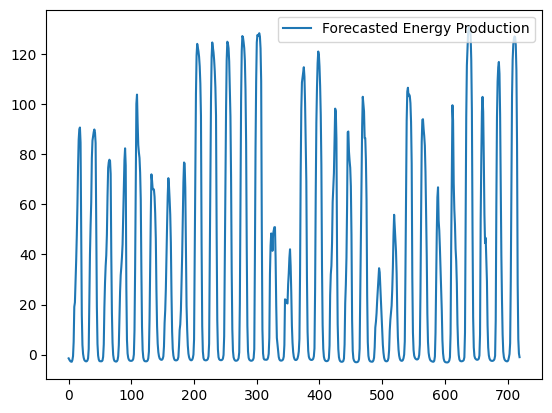

array([[-1.47041782e+00],
       [-1.93160990e+00],
       [-2.38295426e+00],
       [-2.65386031e+00],
       [-2.80206886e+00],
       [-2.81602627e+00],
       [-2.11946480e+00],
       [-5.84961483e-01],
       [ 5.12409401e+00],
       [ 1.90597844e+01],
       [ 2.08462714e+01],
       [ 2.85604869e+01],
       [ 3.74831565e+01],
       [ 4.75136819e+01],
       [ 5.96283498e+01],
       [ 7.49410528e+01],
       [ 8.57615038e+01],
       [ 8.98499031e+01],
       [ 9.06421641e+01],
       [ 8.46140039e+01],
       [ 5.00949317e+01],
       [ 1.58294990e+01],
       [ 3.89758423e+00],
       [ 2.97174263e-01],
       [-1.22683819e+00],
       [-2.10002477e+00],
       [-2.43222484e+00],
       [-2.61203825e+00],
       [-2.67605077e+00],
       [-2.60217228e+00],
       [-2.27404084e+00],
       [-1.44385312e+00],
       [ 2.29109078e+00],
       [ 2.20024582e+01],
       [ 4.00507454e+01],
       [ 5.15569568e+01],
       [ 6.06970313e+01],
       [ 7.83802866e+01],
       [ 8.5

In [166]:
future_predictions = predict_future_values(model, future_df, seq_length)

# Plot future predictions
plt.plot(future_predictions, label="Forecasted Energy Production")
plt.legend()
plt.show()
future_predictions

In [167]:
submission_df = pd.DataFrame(columns=['ds', 'Energia'])
submission_df['ds'] = future_df["ds"]
submission_df['Energia'] = future_predictions
submission_df.head()


,ds,Energia
0,2024-09-01 00:00:00,-1.470418
1,2024-09-01 01:00:00,-1.931610
2,2024-09-01 02:00:00,-2.382954
3,2024-09-01 03:00:00,-2.653860
4,2024-09-01 04:00:00,-2.802069


In [168]:
submission_filename = 'Challenge1_GroupX.csv'  # Replace 'GroupX' with your team name if needed

#print(f"✅ Submission file saved as '{submission_filename}'")
pd.options.display.float_format = "{:.6f}".format


# Clip the values of 'Energia' column lower than 0.5 to 0
submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)
for i in submission_df.index:
    if submission_df.loc[i, 'ds'].hour in [22, 23, 0, 1, 2, 3, 4, 5, 6, 7]:
        submission_df.loc[i, 'Energia'] = 0
submission_df.to_csv(submission_filename, index=False, sep=";", decimal=",")
submission_df.head(20)

,ds,Energia
0,2024-09-01 00:00:00,0.000000
1,2024-09-01 01:00:00,0.000000
2,2024-09-01 02:00:00,0.000000
3,2024-09-01 03:00:00,0.000000
4,2024-09-01 04:00:00,0.000000
5,2024-09-01 05:00:00,0.000000
6,2024-09-01 06:00:00,0.000000
7,2024-09-01 07:00:00,0.000000
8,2024-09-01 08:00:00,5.124094
9,2024-09-01 09:00:00,19.059784


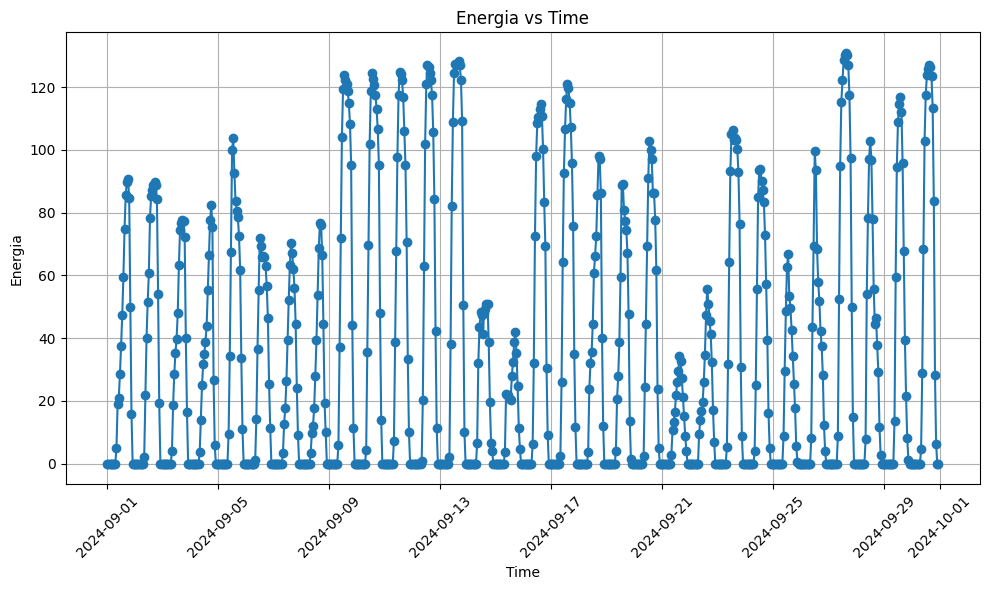

In [169]:
import matplotlib.pyplot as plt

# Plot the values of Energia against time
plt.figure(figsize=(10, 6))
plt.plot(submission_df['ds'], submission_df['Energia'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Energia')
plt.title('Energia vs Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
